**IMPORT LIBRARIES**

In [1]:
# IMPORT LIBRARIES

In [2]:
%%capture
!pip install category_encoders==2.*

In [3]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

# pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 

# permutation importance
from sklearn.inspection import permutation_importance 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**WRANGLE DATA**

In [4]:
# WRANGLE DATA
# https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [5]:
!unzip \*.zip  && rm *.zip

Archive:  Unit_2_Project_data.zip
  inflating: weatherAUS.csv          


In [6]:
DATA_PATH = 'weatherAUS.csv'

In [7]:
def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')  # Making date the index

  df = df.replace('SydneyAirport', 'Sydney')                          # Combine Sydney Airport with larger Sydney Data

  df = df.loc[df['Location'] == 'Sydney']                             # Only want to look at data for Sydney

  df = df.drop(columns= 'WindGustDir')                                # Dropping columns that have many null values
  df = df.drop(columns = 'WindGustSpeed')
  df = df.drop(columns = 'RainToday')                                 # Dropped column with repetitive information - "Rainfall" column is already present

  df = df.dropna()                                                    # Dropping all rows with any remaining null values

  return df

df = wrangle(DATA_PATH)

In [8]:
df.tail()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,
2017-06-21,Sydney,8.6,18.6,0.2,2.0,7.8,NNW,S,13.0,28.0,69.0,67.0,1025.7,1025.3,2.0,2.0,13.3,17.7,No
2017-06-22,Sydney,9.5,17.8,0.2,2.0,9.2,NNW,SSE,9.0,9.0,74.0,70.0,1028.3,1024.6,2.0,2.0,14.3,16.8,No
2017-06-23,Sydney,8.7,19.4,0.0,2.4,2.7,NW,NW,13.0,15.0,83.0,57.0,1020.8,1014.7,6.0,6.0,10.9,18.2,No
2017-06-24,Sydney,9.4,19.9,0.0,1.4,9.3,WNW,W,22.0,28.0,61.0,41.0,1017.3,1015.2,5.0,2.0,12.9,19.3,No
2017-06-25,Sydney,6.8,19.5,0.0,3.4,9.4,NW,WSW,19.0,28.0,67.0,42.0,1018.4,1015.2,1.0,1.0,11.9,17.9,No


In [9]:
df.shape

(5530, 19)

**FEATURE MATRIX AND TARGET VECTOR**

In [10]:
# SPLIT X & y
Target = 'RainTomorrow'
X = df.drop(columns = Target)
y = df[Target]

In [11]:
y.head()

Date
2008-02-01    Yes
2008-02-02    Yes
2008-02-03    Yes
2008-02-04    Yes
2008-02-06    Yes
Name: RainTomorrow, dtype: object

In [12]:
y.value_counts(normalize=True)

No     0.750814
Yes    0.249186
Name: RainTomorrow, dtype: float64

In [13]:
y.value_counts()

No     4152
Yes    1378
Name: RainTomorrow, dtype: int64

In [14]:
# Create test set BEFORE undersampling

In [15]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, train_size=.90, test_size=.10, random_state=42)

In [16]:
X_test.shape, y_test.shape

((553, 18), (553,))

In [17]:
# UNDERSAMPLE
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state = 42, replacement = False)

X_rus, y_rus = rus.fit_resample(X_temp, y_temp)

In [18]:
X_rus.shape, y_rus.shape

((2454, 18), (2454,))

In [19]:
y_rus.value_counts()

Yes    1227
No     1227
Name: RainTomorrow, dtype: int64

**SPLIT DATA INTO TRAIN, VALIDATION, TEST**

In [20]:
# SPLIT INTO TRAIN & VALIDATION
X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, train_size=.80, test_size=.20, random_state=42)

In [21]:
X_train.shape, y_train.shape

((1963, 18), (1963,))

In [22]:
X_val.shape, y_val.shape

((491, 18), (491,))

**ESTABLISH BASELINE**

In [23]:
# ESTABLISH BASELINE FOR CLASSIFICATION PROBLEM (Majority class BEFORE undersampling)
print(y.value_counts(normalize=True).max())

0.7508137432188066


**TRAIN MODELS**

In [24]:
# BUILD LINEAR MODEL (Logistic Regression)
model_logr = make_pipeline(
            OneHotEncoder(use_cat_names=True),
            SimpleImputer(strategy='mean'),
            StandardScaler(),
            LogisticRegression()
)

model_logr.fit(X_train, y_train);

In [25]:
# BUILD TREE-BASED MODEL
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42, n_jobs=-1)
)

model_xgb.fit(X_train,y_train);

**CHECK METRICS**

In [26]:
# CHECK ACCURACY ON VALIDATION SET

In [27]:
# LINEAR MODEL (Logistic Regression)
print('Training Accuracy:', model_logr.score(X_train, y_train))
print('Validation Accuracy:', model_logr.score(X_val, y_val))           

Training Accuracy: 0.782475802343352
Validation Accuracy: 0.7596741344195519


In [28]:
# TREE-BASED MODEL (XGBoost)
print('Training Accuracy', model_xgb.score(X_train, y_train))
print('Validation Accuracy', model_xgb.score(X_val, y_val))

Training Accuracy 0.8441161487519103
Validation Accuracy 0.7881873727087576


**TUNE BEST MODEL**

In [29]:
# TUNE BEST MODEL ON VALIDATION SET
model_xgb_tune = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state= 42, n_estimators=80, max_depth = 7, n_jobs=-1)
)

model_xgb_tune.fit(X_train,y_train);

In [30]:
print('Training Accuracy', model_xgb_tune.score(X_train, y_train))
print('Validation Accuracy', model_xgb_tune.score(X_val, y_val))

Training Accuracy 0.9923586347427407
Validation Accuracy 0.8044806517311609


**COMMUNICATE RESULTS**

In [31]:
model_final = model_xgb_tune

In [32]:
# FINAL RESULTS ON TEST SET
print('Test Accuracy', model_final.score(X_test, y_test))

Test Accuracy 0.8083182640144665


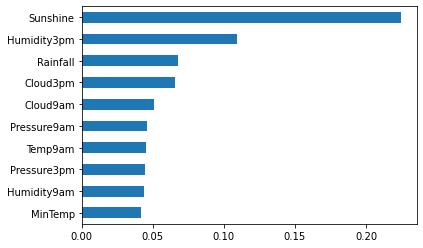

In [33]:
# VISUAL WITH MOST IMPORTANT FEATURE
importances = model_xgb_tune.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');